# Landsat calibration using MODIS SST
Create matchups between Landsat and MODIS SST data near Cosgrove, West Antarctica
to produce a calibration for Landsat SSTs

In [1]:
# Import libraries and modules
%config InlineBackend.figure_format = 'svg'
%matplotlib widget
import pandas as pd
import xarray as xr
import geopandas as gpd
from datetime import date, timedelta, datetime
import numpy as np
import matplotlib.pylab as plt
from matplotlib import colors
from matplotlib.pylab import rcParams
from matplotlib.patches import Polygon as Pgon
import cartopy.crs as ccrs
import cartopy

import os
from cycler import cycler
import pyproj
from pyproj import Proj, transform
from sklearn.neighbors import BallTree
import pytz
import pygmt
import gc
import copy
import random
import statsmodels.formula.api as sm
import scipy.stats as stats
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
# from shapely.geometry.polygon import Polygon
from shapely.geometry import Point, Polygon
from pathlib import Path
import math
from scipy.odr import Model, RealData, ODR
from tqdm.notebook import trange, tqdm
import seaborn as sns

import earthaccess

# For LST file masking
import pystac_client
import intake
from rasterio.session import AWSSession
import boto3

import warnings
warnings.filterwarnings('ignore')

In [2]:
#For color cycling in plots that is color blind friendly...make new ones at "I want hue" tools.medialab.sciences-po.fr/iwanthue
color_cycler = cycler(color=["#6777cf","#adba49","#c65ca0","#5fa042","#683287","#72ce7b","#c44a48","#45c7a9","#933c1d","#d0803f","#ac9239","#317c39"])
colorline_cycler = (cycler(color=["#75a141","#6c61b9","#bc4d45","#c1913d","#b85298","#4aa8e8"]) +
                 cycler(linestyle=['-','--',':','-.','-','--']))
rcParams['axes.prop_cycle'] = cycler('color', color_cycler)

## Build Landsat - MODIS SST matchups

In [3]:
# Set paths and important variables and Calibration region bounding box

basepath = Path('/home/jovyan/Landsat_SST_algorithm')
spacing = [990,-990] # 990m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
param = 'sea_surface_temperature'
size_threshold = 30

location = 2             # 0 and 1 are the Cosgrove and Dotson Polynya calibration areas, respectively
surf_temp = 'SST'        # 'SST' and 'LST' are for the Landsat SST and LST algorithms respectively

# Set location bounds
if location==1:
    pathdir = 'DotsonPolynya'
    latboundsC = [ -73.9 , -73.5 ] # Dotson polynya
    lonboundsC = [ -113 , -111.5 ]
    dfloc = 'Dotson'
elif location==0:
    pathdir = 'Cosgrove'
    latboundsC = [ -73.5 , -73.42 ] # near Cosgrove
    lonboundsC = [ -103.0 , -102.0 ]
    dfloc = 'Cosgrove'
elif location==2:
    pathdir = 'Burke'
    latboundsC = [ -73.81 , -73.42 ] # south of Burke
    lonboundsC = [ -104.2 , -103.8 ]
    dfloc = 'Burke'
if location==3:
    pathdir = 'DotsonIntercomp'
    latboundsC = [ -74.2 , -74.11 ] # Dotson plume for intercomparison
    lonboundsC = [ -113.5 , -113.17 ]
    dfloc = 'DotsonIntercomp'

# Coefficients for calibration
# SST
sstcalib_m = 0.76 
sstcalib_b = 0.55 

# LST
lstcalib_m = 0.80
lstcalib_b = 1.00

modmin = -1.9
LSTmin = np.around(modmin/lstcalib_m - lstcalib_b,2) 
SSTmin = np.around(modmin/sstcalib_m - sstcalib_b,2) # should be about -2.0

# Uncertainties used in ODR propagation of error
modis_uncertainty = 0.44  # long wave sst ocean color atbd
sst_uncertainty = 0.3 # USGS Landsat stray light notice
lst_uncertainty = 1.0 # gerace 2020
pix_uncertainty = np.sqrt((1000*1000)/(100*100)) # MODIS 1km x 1km and Landsat 100m x 100m


# For calibrated SST runs
if surf_temp=='SST':
    if location==3:
        sstpath = basepath / f'Data/SST/Validation/{pathdir}/'
    else:
        sstpath = basepath / f'Data/SST/MODcalib/{pathdir}/'
    tif = 'tif'
    thresh = SSTmin
    calib_m = sstcalib_m
    calib_b = sstcalib_b
    
# If running for LST comparisons
elif surf_temp=='LST':
    if location==3:
        sstpath = basepath / f'Data/SST/LST/Calibration/DotsonPolynya/'
    else:
        sstpath = basepath / f'Data/SST/LST/Calibration/{pathdir}/'
    tif = 'TIF'
    thresh = LSTmin
    calib_m = lstcalib_m
    calib_b = lstcalib_b

In [4]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [5]:
def lsat_reproj(old_cs,new_cs,lbox):
    '''
    bbox comes out with the points out of order for making a polygon though pairs are correct. Order is 0,3,1,2 when done in normal projection. 
    Haven't tested for flipped grid.
    '''
    
    test_threshold = 0.5
    
    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)
    
    ULX,LRY,LRX,ULY = lbox

    [lULX,lLRX], [lULY,lLRY] =  transform(inProj,outProj,[ULX,LRX], [ULY,LRY], always_xy=True)
    [cULX,cLRX], [cULY,cLRY] =  transform(outProj,inProj,[lULX,lLRX], [lULY,lLRY], always_xy=True)
    [lLLX,lURX], [lLLY,lURY] =  transform(inProj,outProj,[ULX,LRX], [LRY,ULY], always_xy=True)
    [cLLX,cURX], [cLLY,cURY] =  transform(outProj,inProj,[lLLX,lURX], [lLLY,lURY], always_xy=True)

    if LRY>ULY:
        bbox = [(lULX,lLLY),(lLLX,lULY),(lLRX,lURY),(lURX,lLRY)]
        print('lsat_reproj flipped orientation')
    else:
        bbox = [(lULX,lULY),(lLLX,lLLY),(lLRX,lLRY),(lURX,lURY)]
        print('lsat_reproj normal orientation')

    checkbox = np.array([cULX,cULY,cLRX,cLRY])
    if np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY])) > test_threshold:
        print(f"Round-trip transformation error 1 of {np.linalg.norm(checkbox - np.array([ULX,ULY,LRX,LRY]))}")
    checkbox = np.array([cLLX,cLLY,cURX,cURY])
    if np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY])) > test_threshold:
        print(f"Round-trip transformation error 2 of {np.linalg.norm(checkbox - np.array([ULX,LRY,LRX,ULY]))}")
    print (f'bbox={bbox}')
    print (f'lbox={lbox}')
    print (f'checkbox={checkbox}')
    
    return bbox,checkbox

##########################

def crop_xarray_dataarray_with_polygon(dataarray, polygon):
    """
    Crop an xarray.DataArray using a polygon.
    
    Parameters:
    - dataarray: xarray.DataArray with x and y coordinates.
    - polygon: Shapely Polygon object defining the crop area.
    
    Returns:
    - Cropped xarray.DataArray.
    """
    # Generate a 2D array of shapely Point objects for each grid point
    lon, lat = np.meshgrid(dataarray.x.values, dataarray.y.values)
    points = np.vectorize(Point)(lon, lat)
    
    # Create a mask where points within the polygon are True
    mask_func = np.vectorize(polygon.contains)
    mask = mask_func(points)
    
    # Convert the mask to an xarray.DataArray
    mask_da = xr.DataArray(mask, dims=["y", "x"], coords={"y": dataarray.y, "x": dataarray.x})
    
    # Apply the mask to the dataarray, cropping to the polygon
    # Use where method with drop=True to drop values outside the polygon
    cropped_dataarray = dataarray.where(mask_da, drop=True)
    
    return cropped_dataarray

##########################

def subset_img(da,polarx,polary):
    '''
    ***Only works for square grid cropping along the orientation of the grid (not when cropping along lat/lon in a 3031 grid
    
    Subset image in xarray to desired coordinates. Because Landsat polar stereo projection can be oriented
    in many different directions, when coordinates to subset an image are reprojected from lat/lon they may get 
    flipped for which is larger in the pair. This function checks to make sure we are getting a proper subset and 
    avoids 0 pixels on the x or y axis. 
    
    Note: Input shape dimensions and dataarray v. dataset changes things so input needs to be a dataarray w 
          2 dimensions (x,y)
    
    Input:
    da = xarray DataArray to be subset
    polarx = x coordinates to subset by in polar stereographic projection
    polary = y coordinates to subset by in polar stereographic projection
    
    Output:
    ls_sub = subset xarray DataArray
    
    '''
    # ***Landsat shape dimensions are one fewer than they are for LandsatCalibration [0,1] not [1,2], no .to_array() or Band
    ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[0],polarx[1]))

    # Check for right dimensions because y order changes sometimes
    if (ls_sub.x.shape[0]==0) & (ls_sub.y.shape[0]==0):
        print ('L8 x and y shapes are 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[1],polarx[0]))
    elif ls_sub.y.shape[0]==0:
        print ('L8 y shape is 0')
        ls_sub = da.sel(y=slice(polary[0],polary[1]),x=slice(polarx[0],polarx[1]))
    elif ls_sub.x.shape[0]==0:
        print ('L8 x shape is 0')
        ls_sub = da.sel(y=slice(polary[1],polary[0]),x=slice(polarx[1],polarx[0]))
    print(da.shape)
    print(ls_sub.shape)
    
    return ls_sub
    
##########################

def crosses_idl(coords):
    '''
    Determine if the set of coordinates crosses the International Dateline in a way that will mess up the creation of a polygon
    
    Variables:
    coords = list of lon, lat tuples
    
    Output:
    True or False
    '''
    
    for (lon1, lat1), (lon2, lat2) in zip(coords, coords[1:]):
        if abs(lon1 - lon2) >= 180:
            return True
    return False

##########################

# Preprocess to add time dimension and the file name to open_mfdataset for landsat using the filename
def add_time_dim(ds):
    lstr = ds.encoding["source"].split("LC0",1)[1]
    times = pd.to_datetime(lstr[14:22]+lstr[38:44], format='%Y%m%d%H%M%S')
    idee = ds.encoding["source"].split("/")[8][:-4] # The first number depends on how many subdirectories the file is in
    return ds.assign_coords(time=times,ID=idee)

In [6]:
def find_MODIS(lonboundsC,latboundsC,ls_scene):
    '''
    Finds the MODIS scene most closely coincident to a Landsat scene
    Uses full Landsat scene extent, not cropped
    
    Variables: 
    ls_scene = xarray for one Landsat scene
    
    Outputs:
    mod_scene = xarray of MODIS SST image coincident in time with the Landsat scene
    granules[ind]['umm']['GranuleUR'] = modis file name
    min_time = the time difference between the Landsat image acquisition and chosen MODIS image
    
    **not done, Differences from NLSST: 0.0 used as percent_dif requiring 100% overlap between MODIS and Landsat here since the subset area is so small
    '''
    
    mbox = (lonboundsC[0],latboundsC[0],lonboundsC[1],latboundsC[1]) #east, south,west,north

    # Construct a polygon to select a best fit MODIS image based on overlap
    # Using the entire Landsat image
    ls_scene_reproj = ls_scene.rio.reproject("EPSG:4326")
    xmin,xmax,ymin,ymax = ls_scene_reproj.x.values[0],ls_scene_reproj.x.values[-1],ls_scene_reproj.y.values[0],ls_scene_reproj.y.values[-1]
    lsatpoly = Polygon([(xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin),(xmin,ymin)])
    
    # Get date/time for Landsat image and search for corresponding MODIS imagery  
    ls_time = pd.to_datetime(ls_scene.time.values)
    calc_dt = datetime.strptime(ls_time.strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S')
    start_dt = (calc_dt + timedelta(days=-0.5)).strftime('%Y-%m-%d %H:%M:%S')
    end_dt = (calc_dt + timedelta(days=0.5)).strftime('%Y-%m-%d %H:%M:%S')
    
    # Gather all files from search location from Terra and Aqua for the same day as the Landsat image
    granules = earthaccess.search_data(
        short_name='MODIS_T-JPL-L2P-v2019.0',
        bounding_box=mbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules2 = earthaccess.search_data(
        short_name='MODIS_A-JPL-L2P-v2019.0', #MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_NIGHTTIME_V2019.0
        bounding_box=mbox,
        # Day of a landsat scene to day after - searches day of only
        temporal=(start_dt,end_dt)
    )
    granules = granules + granules2
    print (f'{len(granules)} TOTAL MODIS granules')

    # Accept only MODIS granules that overlap at least a perscribed amount with Landsat, in this case 100% => percent_dif=0.0
    best_grans = []
    for granule in granules:
        try:
            granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
        except Exception as error:
            print(error)
            continue
            # Would love to raise an exception for a valueerror except for GEOSError
        for num in range(len(granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'])):
            try:
                # Extract points, make into a polygon
                map_points = [(xi['Longitude'],xi['Latitude']) for xi in granule['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons'][num]['Boundary']['Points']]
                pgon = Polygon(map_points)
                percent_dif = lsatpoly.difference(pgon).area/lsatpoly.area
                # If the polygon covers the landsat area, check to make sure it doesn't cross the international date line with a messed up polygon (these are searched wrong in earthaccess so probably need adjustment there)
                if percent_dif == 0.0:
                    if crosses_idl(map_points):
                        print (f'A granule has messed up polygon that likely crosses the International DateLine')
                    else:
                        best_grans.append(granule)
                        continue
            except Exception as error:
                print(error)
                # Would love to raise an exception for a valueerror except for GEOSError
    print(f'{len(best_grans)} remaining MODIS granules')

    # Find MODIS image closest in time to each Landsat image
    # Make Landsat datetime timezone aware (UTC)
    Mdates = [pd.to_datetime(granule['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']) for granule in best_grans]
    ind = Mdates.index(min( Mdates, key=lambda x: abs(x - pytz.utc.localize(ls_time))))
    time_dif = abs(Mdates[ind] - pytz.utc.localize(pd.to_datetime(ls_time)))
    print(f'Time difference between MODIS and Landsat: {time_dif}')

    mod_scene = xr.open_dataset(earthaccess.open(best_grans[ind:ind+1])[0])
    mod_scene = mod_scene.rio.write_crs("epsg:4326", inplace=True) 
    
    return mod_scene, granules[ind]['umm']['GranuleUR'],time_dif

##########################  

def get_wv(ls_scene,mod07,spacing,param):
    '''
    ***This is copied in LandsatCalibration, modifications have been made but some may tranfer
    
    Create MODIS files aligned and subsampled to Landsat
    
    Variables:
    ls_scene = xarray dataset of a Landsat scene
    mod07 = xarray datarray with MODIS data
    spacing = list of desired spatial resolution of output data from the alignment of MODIS to Landsat in y and x (e.g.,[300,-300])
    param = string for desired dataset from MODIS file
    
    Output:
    WV_xr = xarray dataarray of Landsat aligned and upsampled modis data from desired dataset
    
    Differences from NLSST: scene is not a parameter (used for test_gridcoords), SST gets extracted differently into data/lat/lon
    
    '''
    # Read in desired variables and paths
    
    uniqWV = []

    ULX = ls_scene.x[0] 
    ULY = ls_scene.y[0]
    LRX = ls_scene.x[-1]
    LRY = ls_scene.y[-1] 
    box = [ULX,LRX,ULY,LRY]
    
    #Extract desired datasets from MODIS file
    if param == 'sea_surface_temperature': 
        data = mod07[0,:,:]
        lat, lon = mod07.lat, mod07.lon
    else: 
        data = mod07[param].values
        lat, lon = mod07.Latitude, mod07.Longitude    

    # Produce indicies for aligning MODIS pixel subset to match Landsat image at 4000m (or 300)resolution
    indiciesMOD,lines,samples = MODISlookup(mod07,ls_scene,box,spacing)

    # Align MODIS SST to Landsat on slightly upsampled grid # have the option to output `uniqImgWV` if want to know range of data
    dataOutWV_xr = alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing)

    # Resample MODIS to Landsat resolution and interpolate with B-spline
    # Output of shape fits and need to adjust x and y coords cuz are wrong
    ups_factor = 30/spacing[0]
    WV_upsample = pygmt.grdsample(grid=dataOutWV_xr, spacing=f'{ups_factor}k') # ,interpolation='b' if prefer to interpolate with bspline but don't think it is useful here

    # Put into Xarray
    latnew = ls_scene.y[:WV_upsample.shape[0]].values
    lonnew = ls_scene.x[:WV_upsample.shape[1]].values
    if dataOutWV_xr.latitude[0]!=latnew[0]:
        print('Aligned y dim needs to start with the same coordinate as ls_scene')
    if dataOutWV_xr.longitude[0]!=lonnew[0]:
        print('Aligned x dim needs to start with the same coordinate as ls_scene')
    
    WV_xr = xr.DataArray(WV_upsample,name='SST',dims=["y","x"], coords={"latitude": (["y"],latnew), "longitude": (["x"],lonnew)})
    WV_xr = WV_xr.rio.write_crs("epsg:3031", inplace=True)
    WV_xr = WV_xr.rename({'longitude':'x','latitude':'y'})
    WV_xr = WV_xr.set_index(x='x')
    WV_xr = WV_xr.set_index(y='y')
    
    return WV_xr
           
##########################           

def MODISlookup (mod07,ls_scene,box,spacing):
    '''
    Look up atmospheric consituents from MODIS product for each Landsat pixel
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file 
    # and Shane Grigsby

    Variables:    
    mod07 = xarray with MODIS data with crs 4326 assigned
    ls_scene =  Landsat xarray DataArray
    box = list with [left easting,right easting,top northing,bottom northing]
    spacing = desired pixel size for extraction, list of [east/west, north/south] 
          (recommend choosing a number that allows for fast calculations and even division by 30)

    Output:
    indiciesMOD = indicies used to project MODIS pixels to match Landsat pixels
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    x1,y1 = x and y coordinates for grid
    
    Differences from NLSST: lat/lon variables named differently in SST vs WV files, no interpolation,
    test_gridcoords does not use `scene`, don't need to output lat/lon because do not interpolate and make 
    new ones
    
    '''
    test_threshold = 5 
    
    lat, lon = mod07.lat, mod07.lon # Different for SST vs WV
    
    # Test lat is in correct range
    if ~((lat <= 90) & (lat >= -90)).all():
        print('MODIS latitude not between -90 and 90')
    # Test lon is in correct range
    if ~((lon <= 180) & (lon >= -180)).all():
        print('MODIS longitude not between -180 and 180')

    # Get the existing coordinate system
    old_cs = ls_scene.rio.crs # 'epsg:3031'
    new_cs = mod07.rio.crs # 'epsg:4326'

    # Create a transform object to convert between coordinate systems
    inProj = Proj(init=old_cs)
    outProj = Proj(init=new_cs)

    # Parse coordinates and spacing to different variables
    west,east,north,south = box
    ewspace,nsspace = spacing

    # Setting up grid, x coord from here to here at this spacing, mesh grid makes 2D
    samples = len(np.r_[west:east+1:ewspace])
    lines = len(np.r_[north:south-1:nsspace])#ns space is -300, could also do 30 instead of 300, but would just have duplicate pixels
    if lines==0:
        lines = len(np.r_[south:north-1:nsspace])
        
    # x1, y1 = np.meshgrid(np.r_[west:east:ewspace],np.r_[north:south:nsspace]) # offset by 1 meter to preserve shape
    ewdnsamp = int(spacing[0]/30)
    nsdnsamp = int(spacing[1]/30)

    # Set up coarser sampling and check to make sure is in the same orientation as the original Landsat grid
    xresamp = ls_scene.x.isel(x=slice(None, None, ewdnsamp)).values
    if xresamp[0]!=ls_scene.x.values[0]:
        xresamp = ls_scene.x.isel(x=slice(None, None, -ewdnsamp)).values
        
    yresamp = ls_scene.y.isel(y=slice(None, None, nsdnsamp)).values
    if yresamp[0]!=ls_scene.y.values[0]:
        yresamp = ls_scene.y.isel(y=slice(None, None, -nsdnsamp)).values

    x1, y1 = np.meshgrid(xresamp,yresamp)
    LScoords = np.vstack([x1.ravel(),y1.ravel()]).T
    if (LScoords[0,0]!=ls_scene.x.values[0]) |  (LScoords[0,1]!=ls_scene.y.values[0]):
        raise Exception('Landsat coordinates do not match expected during MODIS lookup')

    # Ravel so ND can lookup easily
    # Convert from LS map coords to lat lon --> x = lon, y = lat (usually?)
    # Test that reprojection is working correctly on first and last grid point using round-trip transformation
    xs1, ys1 =  transform(inProj,outProj,LScoords[0,0], LScoords[0,1], radians=True, always_xy=True)
    xsl1, ysl1 =  transform(outProj,inProj,xs1, ys1, radians=True, always_xy=True)
    if np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:]) > test_threshold:
        print(f"Round-trip transformation error for point {LScoords[0,:]}, {np.linalg.norm(np.array([xsl1, ysl1]) - LScoords[0,:])}")
    else:
        # If passes, run on entire grid
        xs, ys =  transform(inProj,outProj,LScoords[:,0], LScoords[:,1], radians=True, always_xy=True)

    # Produce landsat reprojected to lat/lon and ensure lat is in 0 column
    grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T
    # Test that lines and samples match grid_coords
    if len(grid_coords) != lines*samples:
        raise Exception(f'Size of grid coordinates do not match low resolution Landsat dims: {len(grid_coords)} vs. {lines*samples}. Check that spacing is negative for y')
    MODIS_coords = np.vstack([lat.values.ravel(),lon.values.ravel()]).T
    MODIS_coords *= np.pi / 180. # to radians
    
    # Build lookup, haversine = calc dist between lat,lon pairs so can do nearest neighbor on sphere - if did utm it would be planar
    MOD_Ball = BallTree(MODIS_coords,metric='haversine') #sklearn library
    distanceMOD, indiciesMOD= MOD_Ball.query(grid_coords, dualtree=True, breadth_first=True)
        
    return indiciesMOD,lines,samples

##########################

def test_gridcoords(xs,ys):
    '''
    Test to ensure grid lat and lon are not swapped during reprojection and output grid coordinates
    that have been raveled and stacked for input into BallTree. There is some uncertainty only when the image is
    taken between -60 and -90 longitude because lat and lon can have the same values.
    
    Variables:
    xs = 1D radians representing longitude 
    ys = 1D radians representing latitude
    
    Output:
    grid_coords = two columns of x/y radian pairs representing lon/lat
    
    Differences from NLSST: elif is different than NLSST pipeline
    '''
    
    # Convert radians to lat/lon
    x_check = xs * 180. / np.pi
    y_check = ys * 180. / np.pi
    
    # We know lat is ys and lon is xs if this is true so goes in 0 column position to match MODIS
    if ((-90 <= y_check) & (y_check <= -60)).all() & ~((-90 <= x_check) & (x_check <= -60)).all():
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T # note y / x switch (i.e., lat long convention)
        print('Latitude in proper position')

    # A small subset of data have lat and lon that falls between -60 and -90 so test if the landsat metadata confirms that
    elif ((-90 <= y_check) & (y_check <= -60)).all():
        # xs is latitude if not and goes in 0 column position
        grid_coords = np.vstack([ys.ravel(),xs.ravel()]).T 
        print('Latitude in uncertain position, may be incorrect')

    # Otherwise xs is latitude and goes in 0 column position
    else:
        grid_coords = np.vstack([xs.ravel(),ys.ravel()]).T
        print('Latitude in wrong position')
    
    return grid_coords

##########################

def alignMODIS(data,lat,lon,param,indiciesMOD,lines,samples,mod07,ls_scene,spacing):
    '''
    Align MODIS image to Landsat and resample at indicated spacing
    
    Variables:
    data =
    lat = 
    lon = 
    param =
    indiciesMOD =
    lines = 
    samples =
    mod07 = 
    ls_scene =
    spacing =
    
    Output:
    dataOut_xr = 
    
    Not currently set, but can also output: 
    uniqImg = uniq MODIS atm values within area of Landsat image
    '''
    test_threshold = 5
    
    if (np.shape(lat)== np.shape(lon)== np.shape(data))==False:
            raise Exception("Error in creating indicies, lat/lon and data shapes do not match")
            
    # Extract MODIS data into Landsat grid and gather unique data values
    dataOut,uniqImg = uniqueMODIS(data,param,indiciesMOD,lines,samples)
    
    # Check grid directionality and create matching x/y for new grid
    # Define the source and target coordinate reference systems (CRS)
    src_crs = mod07.rio.crs #'epsg:4326'  MODIS
    target_crs = ls_scene.rio.crs #crs[6:] # 'epsg:3031' Landsat

    # Create a PyProj transformer
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
    transformer_test = pyproj.Transformer.from_crs(target_crs, src_crs, always_xy=True)

    # Test that reprojection is working correctly on first and last grid point
    xm1,xm2 = lon[0,0],lon[-1,-1]
    ym1,ym2 = lat[0,0],lat[-1,-1]
    xx,yy = [xm1,xm2], [ym1,ym2]
    xs1, ys1 =  transformer.transform(xx,yy)
    xsl1, ysl1 = transformer_test.transform(xs1, ys1)
    for i,n in enumerate(xsl1):
        if np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - [xx[i],yy[i]]) > test_threshold:
            print(f"Round-trip transformation error for {sceneid}, {np.linalg.norm(np.array([xsl1[i], ysl1[i]]) - xx[i],yy[i])}")

    # Spacing to create x and y parameters at the correct spacing
    red_y = int(abs(spacing[0]/30))
    red_x = int(abs(spacing[1]/30))

    # Set up coarser sampling grid to match spacing and check to make sure is in the same orientation as the original Landsat grid
    xgrid = ls_scene.x.values[0::red_x]
    if len(xgrid)==1:
        xgrid = ls_scene.x.values[0::-red_x]
    if xgrid[0]!=ls_scene.x.values[0]:
        xgrid = np.flip(xgrid)
        print ('Align x flip')
    ygrid = ls_scene.y.values[0::red_y]
    if len(ygrid)==1:
        ygrid = ls_scene.y.values[0::-red_y]
    if ygrid[0]!=ls_scene.y.values[0]:
        ygrid = np.flip(ygrid)
        print ('Align y flip')
    if (xgrid[0]!=ls_scene.x.values[0]) |  (ygrid[0]!=ls_scene.y.values[0]):
        raise Exception(f'Landsat coordinates do not match expected during MODIS align')
    
    # Create xarray from numpy array
    dataOut_xr = xr.DataArray(dataOut,name='SST',dims=["y","x"], coords={"latitude": (["y"],ygrid), "longitude": (["x"],xgrid)})
    
    return dataOut_xr #,uniqImg


##########################

def uniqueMODIS(data,param,indiciesMOD,lines,samples):
    '''
    Extracts data values and unique values from desired MODIS dataset that corresponds to Landsat file
    # Modified from http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    
    Variables: 
    mod07 = xarray with MODIS data with crs 4326 assigned  
    param = 
    indiciesMOD = indicies output for neighest neighbor query from MODIS to Landsat coordinates
    lines = number of lines in Landsat file/MODIS output shape
    samples = number of samples in Landsat file/MODIS output shape
    
    Output:
    dataOut = MODIS atm image subset and aligned to Landsat pixel grid
    uniq = uniq MODIS atm values within area of Landsat image
    
    Differences from NLSST: SST paramater scaling, etc is different
    '''
    # To convert from K to C
    KtoC = -273.15

    # Reproject data from MODIS into corresponding postions for Landsat pixels for the desired dataset
    # Remove unrealistic data/outliers
    if param == 'sea_surface_temperature':  
        #Extract desired datasets from MODIS file from lookup key
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD],(lines,samples)) + KtoC #* # to scale?
        dataOut[dataOut < -3.5] = np.nan
        
    if param == 'Water_Vapor':
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD],(lines,samples))
        dataOut[dataOut < 0] = np.nan
        MODimg = np.array(data.values)
        MODimg[MODimg < 0] = np.nan
        
    if param == 'Total_Ozone':
        # Move to adjusted grid and rescale data
        dataOut = np.reshape(np.array(data.values.ravel())[indiciesMOD],(lines,samples))
        dataOut[dataOut < 225] = np.nan
        dataOut[dataOut > 430] = np.nan
        MODimg = np.array(data.values)
        MODimg[MODimg < 0] = np.nan

    # Get unique values for datasets within Landsat extent
    #uniq, inverse, counts= np.unique(dataOut, return_inverse=True, return_counts=True)
    uniq = set(dataOut[np.isfinite(dataOut)])
    
    return dataOut,uniq # Can also output MODimg and inverse and counts if desired

In [7]:
# Functions to search and open Lansat scenes
'''
Functions to search, open, and analyze Landsat scenes.
Search_stac finds the Landsat scene based on user parameters, 
plot_search plots the locations of the landsat scenes from the search,
landsat_to_xarray takes one of those scenes and puts all bands into an xarray,
and create_masks produces cloud/ice/water masks for the scene. Subset_img 
subsets a landsat scene with coordinates that have been reprojected from lat/lon
and may be flipped in which is larger in the pair. Lsat_reproj can be used to reproject
while ensuring x and y pairs don't get flipped (common converting between espg 3031 and wgs84.
'''

def landsat_to_xarray(sceneid, catalog, bandNames=None):
    """
    Loads selected Landsat bands (and QA layers for later cloud masking) from an 
    AWS S3 bucket (via the STAC item's alternate href) into an xarray Dataset.

    Parameters
    ----------
    sceneid : intake.STAC item
        A single STAC item pointing to Landsat assets.
    bandNames : list of str, optional
        Names of bands to load (e.g., ['red', 'swir16']). If None, all non-thermal
        bands are included by default.

    Returns
    -------
    xr.DataArray
        A 3D xarray DataArray (dimensions: band, y, x) with a scalar coordinate
        for the observation time. The bands will include 'qa_pixel', 'qa_radsat',
        and 'VZA' in addition to any requested reflectance/thermal bands.
    
    Notes
    -------
    If multiple scenes are merged later on, xarray will fill non-overlapping areas with NaNs.
    
    """

    # Retrieve the STAC item from the catalog by its ID
    item = catalog[sceneid.id]

    bands = []
    band_names = []

    if bandNames is None:
        # Get band names
        for k in item.keys():
            M = getattr(item, k).metadata
            if 'eo:bands' in M:
                resol = M['eo:bands'][0]['gsd']
                if resol >= 30: # thermal bands are up sampled from 100 to 30
                    band_names.append(k)
    else:
        band_names = bandNames

    # Add QA bands for creating cloud mask later
    if 'qa_pixel' not in band_names:
        band_names.append('qa_pixel')
    
    band_names.append('VZA')
    band_names.append('qa_radsat')

    # Construct xarray for scene by concatenating all desired bands (including QA)
    for band_name in band_names:
        asset = sceneid.assets[band_name]
        href = asset.extra_fields['alternate']['s3']['href']
        band = xr.open_dataset(href, engine='rasterio', chunks=dict(band=1, x=512, y=512))
        band['band'] = [band_name]
        bands.append(band)
    ls_scene = xr.concat(bands, dim='band')
    ls_scene.coords['id'] = sceneid.id
    ls_scene.coords['time'] = item.metadata['datetime'].strftime('%Y-%m-%dT%H:%M:%S')
    ls_scene = ls_scene['band_data']

    return ls_scene

##########################

def create_masks(ls_scene, cloud_mask=True, ice_mask=False, ocean_mask=False):
    """
    Creates cloud, ice, and ocean masks from a Landsat scene QA band. By default, 
    clouds are labeled as 1, ice as 2, ocean as 3, and all other pixels are NaN.

    Parameters
    ----------
    ls_scene : xarray.DataArray
        A Landsat scene loaded with a 'qa_pixel' band (as created by `landsat_to_xarray`).
    cloud_mask : bool, optional
        Whether to generate the cloud mask. Default is True.
    ice_mask : bool, optional
        Whether to generate the ice mask. Default is False.
    ocean_mask : bool, optional
        Whether to generate the ocean mask. Default is False.

    Returns
    -------
    xarray.DataArray
        The same input xarray object, but with an added `"mask"` coordinate. 
        In that mask, cloud pixels are assigned 1, ice pixels 2, ocean pixels 3, 
        and everything else is set to NaN.
    """
    
    cloud = []
    ocean = []
    ice = []

    qa = ls_scene.sel(band='qa_pixel').astype('uint16')

    n,c = np.unique(qa, return_counts=True)

    for j in range(len(n)):
        longform = f'{n[j]:016b}'
        if (longform[-7]=='0')|(longform[-3]=='1'): #bit 2 and 6 are for cirrus and clear sky
            cloud.append(n[j])
        if longform[-8:]=='11000000': #bit 6 and 7 give clear sky and water, lower bits need to be 0 
            ocean.append(n[j])
        if longform[-7:]=='1100000': #bit 5 and 6 give ice and clear sky 
            ice.append(n[j])

    if 0 in cloud:
        cloud.remove(0)
    if 1 in cloud:
        cloud.remove(1)

    # mask cloud, ice, and ocean
    if cloud_mask==True:
        # cloud is 2
        mask_c = xr.where(qa.isin(cloud), 1, np.nan)

    if ice_mask==True:
        mask_c = xr.where(qa.isin(ice), 2, mask_c)

    if ocean_mask==True:
        mask_c = xr.where(qa.isin(ocean), 3, mask_c)

    ls_scene.coords['mask'] = (('y', 'x'), mask_c.data)
        
    return ls_scene

##########################

def search_stac(url, collection, gjson_outfile=None, bbox=None, timeRange=None, filename=None):
    """
    Search a STAC API for Landsat images based on either:
    - Bounding box and time range, or
    - Specific filename (STAC 'id').

    Parameters:
    -----------
    url : str
        URL to the STAC API.
    collection : str
        Collection name (e.g., "landsat-c2-l2").
    gjson_outfile : str or None
        Output file to save the search result as GeoJSON (optional).
    bbox : list or None
        Bounding box [west, south, east, north] (optional).
    timeRange : str or None
        Time range in ISO format, e.g., '2021-09-01/2023-03-31' (optional).
    filename : str or None
        Exact filename (product ID) to search for (optional).

    Returns:
    --------
    item_collection : pystac.ItemCollection
        Collection of matching STAC items.
    """
    api = pystac_client.Client.open(url)

    if filename:
        # Search by filename (ID)
        search = api.search(
            collections=[collection],
            ids=[filename],
        )
        print(f"Searching for filename: {filename}")
    
    elif bbox and timeRange:
        # Search by bbox and timeRange
        search = api.search(
            bbox=bbox,
            datetime=timeRange,
            collections=[collection],
        )
        print(f"Searching for items in bbox {bbox} and timeRange {timeRange}")
    
    else:
        raise ValueError("Must provide either a filename, or both bbox and timeRange.")

    items = search.item_collection()

    print(f"Found {len(items)} item(s)")

    if gjson_outfile and len(items) > 0:
        items.save_object(gjson_outfile)
    
    return items

###############

def get_lst_mask(lstfile):
    """
    Generates an open ocean mask from a Landsat scene based on the QA band information.

    This function searches for a Landsat scene using a provided filename, loads the 
    'qa_pixel' band, applies cloud, ice, and ocean masking, and then extracts only 
    the open ocean pixels. The output is a mask where open ocean pixels are 1, and 
    all other pixels are NaN.

    Parameters
    ----------
    lstfile : str
        Path or name of the Landsat file used to derive the corresponding STAC search ID.

    Returns
    -------
    numpy.ndarray
        A 2D mask array where open ocean pixels are 1, and all other pixels are NaN.
    """
    filename = lstfile[:-11]
    items = search_stac(url,collection,filename=filename)
    
    # Open stac catalog for some needed info
    catalog = intake.open_stac_item_collection(items)
    sceneid = items[0]
    print(sceneid.id)
    
    scene = catalog[sceneid.id]
    
    # Open all desired bands for one scene
    ls_scene0 = landsat_to_xarray(sceneid,catalog,bandNames=['qa_pixel'])
    ls_scene0 = ls_scene0.rio.write_crs("epsg:3031", inplace=True)
    
    # Create a classification mask, applying cloud, ice, and ocean masks
    ls_scene0 = create_masks(ls_scene0, cloud_mask=True, ice_mask=True, ocean_mask=True)
    
    # Initialize a mask array and set all pixels not classified as open ocean (mask != 3) to NaN
    mask = np.ones(ls_scene0.shape[1:])
    mask[ls_scene0.mask!=3] = np.nan

    try:
        del ls_scene0
    except:
        pass
    
    gc.collect()

    return mask

In [8]:
# Convert bounding box to south polar stereo for checking if landsat has any data in bounding box
# Speeds up process a lot
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the file

bbox,checkbox = lsat_reproj(source_crs,target_crs,(lonboundsC[0],latboundsC[0],lonboundsC[1],latboundsC[1]))

# Create polygon for later cropping
polygon = Polygon([(bbox[0][0],bbox[0][1]),(bbox[3][0],bbox[3][1]),(bbox[2][0],bbox[2][1]),(bbox[1][0],bbox[1][1])])

# Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
minx, miny, maxx, maxy = polygon.bounds
polarx = [minx, maxx]
polary = [miny, maxy]

lsat_reproj normal orientation
bbox=[(-1758211.7101406257, -444895.95878999075), (-1716314.436869494, -434294.3188082189), (-1719304.5331828727, -422301.69752508285), (-1761274.798255307, -432610.5833818861)]
lbox=(-104.2, -73.81, -103.8, -73.42)
checkbox=[-104.2   -73.81 -103.8   -73.42]


In [9]:
# Get Landsat file paths in directory
lsatfiles = os.listdir(sstpath)
lsatfiles = [x for x in lsatfiles if x[-3:] == tif]
lsatfiles.sort()
print (len(lsatfiles))
os.chdir(sstpath)

110


In [10]:
SSTfails = [
 'LC08_L1GT_006112_20221024_20221107_02_T2_152257_Cel.tif',
 'LC08_L1GT_006112_20221024_20221107_02_T2_152257_Cel.tif',
]
LSTfails = [
 'LC08_L1GT_007112_20211215_20211223_02_T2_SW_LST.TIF',
 'LC08_L1GT_007112_20220201_20220211_02_T2_SW_LST.TIF',
 'LC08_L1GT_007112_20221202_20221212_02_T2_SW_LST.TIF',
 'LC08_L1GT_007112_20230204_20230209_02_T2_SW_LST.TIF',
 'LC08_L1GT_008113_20221022_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010112_20221020_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20221020_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_012112_20221018_20221031_02_T2_SW_LST.TIF',
 'LC08_L1GT_008113_20221022_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010112_20221020_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20220105_20220114_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20220121_20220128_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20221020_20221101_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20221105_20221115_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20230108_20230124_02_T2_SW_LST.TIF',
 'LC08_L1GT_010113_20230313_20230321_02_T2_SW_LST.TIF',
 'LC08_L1GT_012112_20221018_20221031_02_T2_SW_LST.TIF'
]

## Search for desired Landsat scenes

In [11]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [12]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/37599/status,
Dashboard: /user/tsnow03/proxy/37599/status,Workers: 4
Total threads: 4,Total memory: 7.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33939,Workers: 0
Dashboard: /user/tsnow03/proxy/37599/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35263,Total threads: 1
Dashboard: /user/tsnow03/proxy/42203/status,Memory: 1.85 GiB
Nanny: tcp://127.0.0.1:33735,


In [13]:
# Define the landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1 - includes L8 and L9

In [ ]:
%%time
# ~1 min 32 sec per image
# If number of MODIS images per satellite is much more than 25, its because there is a ULY,LRY issue

lsat_mod = []
for i in tqdm(range(len(lsatfiles)), desc="Processing"):
    # Check for known repeatedly bad files that will kill the code
    if surf_temp == 'SST':    
        if lsatfiles[i] in SSTfails:
            continue
    elif surf_temp == 'LST':
        if lsatfiles[i] in LSTfails:
            continue
        
    # Concatenate all landsat files into xarray with a time dimension
    ls_scene = xr.open_dataset(lsatfiles[i],chunks=dict(x=512, y=512),engine='rasterio')['band_data'].sel(band=1)
    ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)

    if surf_temp == 'SST':
        times = pd.to_datetime(lsatfiles[i][17:25]+lsatfiles[i][41:47], format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-8])
    elif surf_temp == 'LST':
        # Need to mask LST because not done previously
        mask = get_lst_mask(lsatfiles[i])
        ls_scene = ls_scene * mask
        
        times = pd.to_datetime(lsatfiles[i][17:25]+'120000', format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times,ID=lsatfiles[i][:-4])
        ls_scene = ls_scene - 273.15

    # Subset scene and check that it has the correct dimensions because y order changes sometimes
    ls_scene = subset_img(ls_scene,polarx,polary) # subset so easier to work with
    ls_scene = crop_xarray_dataarray_with_polygon(ls_scene, polygon) # crop data to exact bounding box

    # if location==3:
    # # Calibrate
    # ls_scene = ls_scene * calib_m + calib_b
    
    # # Remove SSTs that are unrealistically cool
    # ls_scene = ls_scene.where(ls_scene >= thresh, np.nan)

    lsID = lsatfiles[i]
    print (lsID)
    
    # Take mean temp, will skip the modis stage if no Landsat data in the calibration region
    try:
        lsat = np.nanmean(ls_scene)
        ls_num = ls_scene.notnull().values.sum()
    except Exception as e:
        print (lsID, e)
        lsat = np.nan

    print(lsat)
    if ~np.isfinite(lsat):
        continue

    # Find coincident MODIS SST scene
    mod_scene, mod_file,time_dif = find_MODIS(lonboundsC,latboundsC,ls_scene)
    print(mod_file)

    try:
        # Acquire and align MODIS data to Landsat

        # To subset to only high quality MODIS temp measurements which doesn't seem to be useful
        # print(mod_scene.quality_level.max().values)
        # mod_temps = mod_scene.sea_surface_temperature.where(mod_scene.quality_level>=4)

        MODsst_xr = get_wv(ls_scene,mod_scene.sea_surface_temperature,spacing,param) #mod_scene.sea_surface_temperature

        # Remove SSTs that are unrealistically cool
        MODsst_xr = MODsst_xr.where(MODsst_xr >= -1.9, np.nan)

        # Crop Landsat image to meet the slightly smaller MODIS image (smaller image results from upsample methods in get_wv2)
        ls_scene = subset_img(ls_scene,[MODsst_xr.x.min(),MODsst_xr.x.max()],[MODsst_xr.y.min(),MODsst_xr.y.max()])

        # Only use MODIS data where cropped Landsat data is also available
        MODsst_xr_sub = MODsst_xr.where(ls_scene.notnull(),np.nan)

        # Take mean temp
        modis = np.nanmean(MODsst_xr_sub)
        MOD_num = MODsst_xr_sub.notnull().values.sum()
    except Exception as e:
        print (mod_file, e)
        modis = np.nan
        MOD_num = 0

    # Take mean using Landsat data only where cropped MODIS data is also available (need to do both)
    try:
        ls_scene_sub = ls_scene.where(MODsst_xr_sub.notnull(),np.nan)
        lsat = np.nanmean(ls_scene_sub)
        ls_num = ls_scene_sub.notnull().values.sum()
    except Exception as e:
        print (lsID, e)
        lsat = np.nan

    # Append file names with SST means from the Cosgrove box
    lsat_mod.append([times,mod_file,modis,MOD_num,lsID,lsat,ls_num,time_dif])
    print (f'MODIS mean: {modis}, Landsat 8: {lsat}')

    try:
        del ls_scene, ls_sub, mod_scene, MODsst_xr, MODsst_xr_sub
    except:
        pass

    gc.collect()

In [ ]:
# Put data into DataFrame and save    
headers = ['DateTime','MODIS_filename','MODIS_SST','MODIS_pix','L8_filename',f'L8_{surf_temp}','L8_pix','time_dif']
lsat_mod_df = pd.DataFrame(lsat_mod,columns=headers)
out_df = basepath / f'Data/MODISvLandsat_{surf_temp}_{dfloc}_20250500.csv'
lsat_mod_df.to_csv(out_df)

In [17]:
print (out_df)

/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_LST_Dotson_20250425


## Calculate calibration bias and trend
Uses a [RANSAC regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html), but provides comparisons to an Ordinary Least Squares regression calculation from statsmodel of the same parameters.

In [10]:
# Read in paired MODIS/Landsat data created above
surf_temp = 'SST'

if surf_temp=='LST':
    thresh = -3.5 # -3.4 is ok too
    pix_thresh = 1300
elif surf_temp=='SST':
    thresh = -3.1
    pix_thresh = 1300
mod_sst_thresh = -1.9

# For Cosgrove region
if surf_temp=='LST':
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_LST_Cosgrove.csv'
    df1 = pd.read_csv(out_df)
    lsat_mod_df_C = df1
else:   
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Cosgrove_lin_scale.csv' 
    df1 = pd.read_csv(out_df)
    lsat_mod_df_C = df1

print(f'Original # matchups at Cosgrove: {lsat_mod_df_C[lsat_mod_df_C.MODIS_SST.notna()].shape[0]}')

lsat_mod_df_C = lsat_mod_df_C[lsat_mod_df_C['MODIS_SST']>=mod_sst_thresh]
lsat_mod_df_C = lsat_mod_df_C[lsat_mod_df_C['MODIS_pix']>=pix_thresh]
lsat_mod_df_C = lsat_mod_df_C[lsat_mod_df_C[f'L8_{surf_temp}']>=thresh]

# For Dotson polynya region
if surf_temp=='LST':
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_LST_Dotson.csv'
    df5 = pd.read_csv(out_df)
    lsat_mod_df_D = df5
else:
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Dotson_lin_scale.csv'  
    df5 = pd.read_csv(out_df)
    lsat_mod_df_D = df5

print(f'Original # matchups at Dotson: {lsat_mod_df_D[lsat_mod_df_D.MODIS_SST.notna()].shape[0]}')

lsat_mod_df_D = lsat_mod_df_D[lsat_mod_df_D['MODIS_SST']>=mod_sst_thresh]
lsat_mod_df_D = lsat_mod_df_D[lsat_mod_df_D['MODIS_pix']>=pix_thresh]
lsat_mod_df_D = lsat_mod_df_D[lsat_mod_df_D[f'L8_{surf_temp}']>=thresh]

# For Burke region
if surf_temp=='LST':
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_LST_Burke.csv'
    df9 = pd.read_csv(out_df)
    lsat_mod_df_B = df9
else:
    out_df = '/home/jovyan/Landsat_SST_algorithm/Data/MODISvLandsat_SST_Burke_lin_scale.csv'
    df9 = pd.read_csv(out_df)
    lsat_mod_df_B = df9

print(f'Original # matchups at Burke: {lsat_mod_df_B[lsat_mod_df_B.MODIS_SST.notna()].shape[0]}')

lsat_mod_df_B = lsat_mod_df_B[lsat_mod_df_B['MODIS_SST']>=mod_sst_thresh]
lsat_mod_df_B = lsat_mod_df_B[lsat_mod_df_B['MODIS_pix']>=pix_thresh]
lsat_mod_df_B = lsat_mod_df_B[lsat_mod_df_B[f'L8_{surf_temp}']>=thresh]

# Concatenate data from both regions
lsat_mod_df_n = pd.concat([lsat_mod_df_B,lsat_mod_df_C,lsat_mod_df_D]) 
lsat_mod_df_bc = pd.concat([lsat_mod_df_B,lsat_mod_df_C]) 
lsat_mod_df_cd = pd.concat([lsat_mod_df_C,lsat_mod_df_D])
lsat_mod_df_bd = pd.concat([lsat_mod_df_B,lsat_mod_df_D])
print(f'Num. good matchups at Cosgrove: {lsat_mod_df_C[lsat_mod_df_C.MODIS_SST.notna()].shape[0]}, at Dotson: {lsat_mod_df_D[lsat_mod_df_D.MODIS_SST.notna()].shape[0]}, at Burke: {lsat_mod_df_B[lsat_mod_df_B.MODIS_SST.notna()].shape[0]}')

Original # matchups at Cosgrove: 35
Original # matchups at Dotson: 65
Original # matchups at Burke: 50
Num. good matchups at Cosgrove: 29, at Dotson: 54, at Burke: 37


In [14]:
# sum_n = lsat_mod_df_n[lsat_mod_df_n.DateTime.dt.month.isin([9,10,11,12,1,3])]
# shld_n = lsat_mod_df_n[lsat_mod_df_n.DateTime.dt.month.isin([2])]
# sum_c = lsat_mod_df_C[lsat_mod_df_C.DateTime.dt.month.isin([9,10,11,12,1,3])]
# sum_bc = lsat_mod_df_bc[lsat_mod_df_bc.DateTime.dt.month.isin([9,10,11,12,1,3])]
# shld_bc = lsat_mod_df_bc[lsat_mod_df_bc.DateTime.dt.month.isin([2])]
# sum_bd = lsat_mod_df_bd[lsat_mod_df_bd.DateTime.dt.month.isin([9,10,11,12,1,3])]
# shld_bd = lsat_mod_df_bd[lsat_mod_df_bd.DateTime.dt.month.isin([2])]
# sum_cd = lsat_mod_df_cd[lsat_mod_df_cd.DateTime.dt.month.isin([9,10,11,12,1,3])]
# shld_cd = lsat_mod_df_cd[lsat_mod_df_cd.DateTime.dt.month.isin([2])]

In [15]:
# # ***check all the february images to see if we need to add a threshold of 2.0C or cut images or if the issue is clouds???
# # shld
# look = lsat_mod_df_n.sort_values('L8_filename')
# look.head(20)

In [11]:
# Orthoganal Regression 
if surf_temp=='LST':
    data0 = lsat_mod_df_n
    landsat_uncertainty = lst_uncertainty
else:
    data0 = lsat_mod_df_n
    landsat_uncertainty = sst_uncertainty

# Original data
x_original = np.array(data0[f'L8_{surf_temp}'])
y_original = np.array(data0['MODIS_SST'])

# Assume these are your uncertainty estimates per observation
sy = np.full_like(y_original, modis_uncertainty * pix_uncertainty)  # Adjusted for resolution mismatch
sx = np.full_like(x_original, landsat_uncertainty)

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model
linear = Model(linear_model)

# Create a RealData object using your DataFrame
data = RealData(x_original, y_original,sx=sx, sy=sy)

# Set up ODR with the model and data
odr = ODR(data, linear, beta0=[1., 0.])

# Run the regression
out = odr.run()

# Use the output
beta = out.beta
beta_err = out.sd_beta

# Print the summary
out.pprint()

# Predicting values using the ODR model
y_pred = linear_model(beta, x_original)

# Get R2
# Calculate Total Sum of Squares (SST)
y_mean = np.mean(y_original)
SST = np.sum((y_original - y_mean)**2)

# Calculate Residual Sum of Squares (SSR)
SSR = np.sum((y_original - y_pred)**2)

# Compute RMSE
rmse = np.sqrt(((y_original - y_pred) ** 2).mean())

# Calculate R^2
R2 = 1 - (SSR / SST)
print("R^2:", np.around(R2,2))
print(f"RMSE: {np.around(rmse,2)}")

Beta: [0.75835618 0.5503407 ]
Beta Std Error: [0.03290455 0.07053005]
Beta Covariance: [[0.29433466 0.59196307]
 [0.59196307 1.35231515]]
Residual Variance: 0.003678497173211255
Inverse Condition #: 0.015694109996945375
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.82
RMSE: 0.26


In [19]:
# # Calculate p-value for ODR **does not have a lot of meaning

# # P-value
# # Initialize variables for bootstrapping
# n_boots = 1000  # number of bootstrap samples
# boot_coeffs = []  # to store coefficients from each bootstrap
# r2_values = [] # to store R2 from each bootstrap

# # Bootstrapping
# for _ in range(n_boots):
#     # Create a bootstrap sample with replacement
#     indices = np.random.choice(range(len(x_original)), size=len(x_original), replace=True)
#     x_boot = x_original[indices]
#     y_boot = y_original[indices]

#     # Fit ODR on the bootstrap sample
#     data_boot = RealData(x_boot, y_boot)
#     odr_boot = ODR(data_boot, Model(linear_model), beta0=[1., 0.])
#     out_boot = odr_boot.run()
#     boot_coeffs.append(out_boot.beta)  # Store the coefficients
    
#     # Predicting values using the ODR model
#     y_pred_boot = linear_model(beta, x_original)
    
#     # Calculate Total Sum of Squares (SST)
#     y_mean = np.mean(y_boot)
#     SST = np.sum((y_boot - y_mean)**2)

#     # Calculate Residual Sum of Squares (SSR)
#     SSR = np.sum((y_original - y_pred_boot)**2)

#     # Calculate R^2
#     r2_boot = 1 - (SSR / SST)
#     r2_values.append(r2_boot)

# # Convert to DataFrame for analysis
# boot_coeffs_df = pd.DataFrame(boot_coeffs, columns=['Slope', 'Intercept'])

# # Calculate p-values for coefficients
# # Here, we're comparing to the original model's coefficients (beta)
# p_values = []
# for col in boot_coeffs_df.columns:
#     p = np.sum(boot_coeffs_df[col] >= beta[list(boot_coeffs_df.columns).index(col)]) / n_boots
#     p_values.append(p)
    
# # Here, we're comparing to the original model's R2
# p_valuesR = np.sum(r2_values >= R2) / n_boots

# print("P-values:", p_values)
# print("P-values for r2:", p_valuesR)

At 95% confidence interval: 0.8+/-0.17, 1.0+/-0.46, n=58


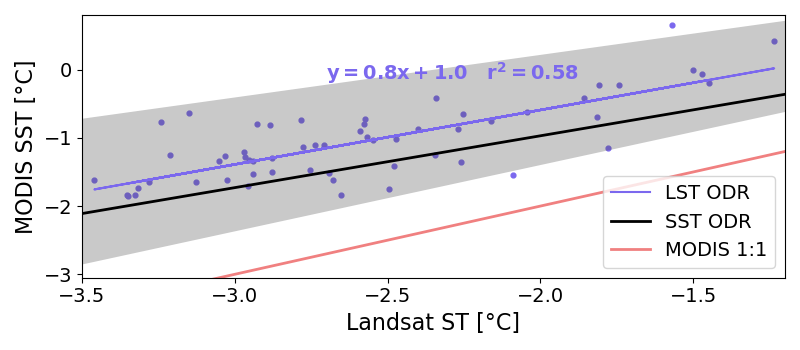

In [20]:
# Plot regression
beta_mdn = [beta[0]-beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_mup = [beta[0]+beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_bdn = [beta[0]-beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
beta_bup = [beta[0]+beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
print(f'At 95% confidence interval: {np.around(beta[0],2)}+/-{np.around(beta_err[0]*1.96,2)}, {np.around(beta[1],2)}+/-{np.around(beta_err[1]*1.96,2)}, n={y_pred.shape[0]}')
xfill = np.array([-4.5,1.5])

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.tick_params(labelsize=14)

# LST data and regression
plt.scatter(x_original, y_original, s=12,color='mediumslateblue')
plt.plot(x_original, y_pred, color='mediumslateblue', label='LST ODR')
plt.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.3, facecolor='0.3')

# Comparison regressions
xi = np.arange(-7.0,5.0,1.0)
plt.plot(xi,xi * sstcalib_m + sstcalib_b,color='k',linewidth=2,label='SST ODR')
plt.plot(xi,xi,color='lightcoral',linewidth=2, label='MODIS 1:1')
    
plt.legend(loc='lower right',fontsize=14)
plt.text(-2.7,-0.15,rf'$\mathbf{{y={np.around(beta[0],2)}x+{np.around(beta[1],2)}\quad r^2={np.around(R2,2)}}}$',color='mediumslateblue', fontweight='bold',fontsize=14)
plt.xlim([-3.5,-1.2])
plt.ylim([-3.05,0.8])
# else: 
#     plt.plot(x_original, y_pred, color='k', label='NLSST Orthogonal Distance Regression')
#     plt.legend(loc='lower right',fontsize=12)
#     plt.text(-2.6,-0.2,f'y={np.around(beta[0],2)}x+{np.around(beta[1],2)}   $r^2$={np.around(R2,2)}',fontsize=14)
#     plt.xlim([-3.2,-0.15])
#     plt.ylim([-2.4,0.9]) 
plt.xlabel('Landsat ST [°C]',fontsize=16)
plt.ylabel('MODIS SST [°C]',fontsize=16)
plt.tight_layout()

In [12]:
# Orthoganal Regression for SST only
dataframes = [
    ('Combined', lsat_mod_df_n),
    ('Burke', lsat_mod_df_B),
    ('Cosgrove', lsat_mod_df_C),
    ('Dotson', lsat_mod_df_D),
]

if surf_temp=='LST':
    landsat_uncertainty = lst_uncertainty
else:
    landsat_uncertainty = sst_uncertainty

# Dictionary to store the results from each DataFrame
odr_results = {}

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model object
linear = Model(linear_model)

# Loop over each DataFrame
for df_name, data0 in dataframes:
    print(f"\n=== Processing {df_name} ===")
    
    # Original data
    x_original = np.array(data0[f'L8_{surf_temp}'])
    y_original = np.array(data0['MODIS_SST'])

    # Assume these are your uncertainty estimates per observation
    sy = np.full_like(y_original, modis_uncertainty * pix_uncertainty)  # Adjusted for resolution mismatch
    sx = np.full_like(x_original, landsat_uncertainty)
    
    # Create a RealData object using your DataFrame
    data = RealData(x_original, y_original,sx=sx, sy=sy)
    
    # Set up ODR with the model and data, providing an initial guess
    odr = ODR(data, linear, beta0=[1., 0.])
    
    # Run the regression
    out = odr.run()
    
    # Retrieve best-fit parameters and their std. dev.
    beta = out.beta
    beta_err = out.sd_beta
    
    # Print the summary
    out.pprint()
    
    # Predicting values using the ODR model
    y_pred = linear_model(beta, x_original)
    
    # Get R2
    # Calculate Total Sum of Squares (SST)
    y_mean = np.mean(y_original)
    SST = np.sum((y_original - y_mean)**2)
    
    # Calculate Residual Sum of Squares (SSR)
    SSR = np.sum((y_original - y_pred)**2)
    
    # Calculate R^2
    R2 = 1 - (SSR / SST)

    # Compute RMSE
    rmse = np.sqrt(((y_original - y_pred) ** 2).mean())
    
    # Print R^2
    print(f"{df_name} R^2:", np.around(R2, 2))
    print(f"RMSE: {np.around(rmse,2)}")
    
    # Store results in a dictionary for later use (plotting, etc.)
    odr_results[df_name] = {
        'beta': beta,
        'beta_err': beta_err,
        'R2': R2,
        'x_original': x_original,
        'y_original': y_original,
        'y_pred': y_pred
    }


=== Processing Combined ===
Beta: [0.75835618 0.5503407 ]
Beta Std Error: [0.03290455 0.07053005]
Beta Covariance: [[0.29433466 0.59196307]
 [0.59196307 1.35231515]]
Residual Variance: 0.003678497173211255
Inverse Condition #: 0.015694109996945375
Reason(s) for Halting:
  Sum of squares convergence
Combined R^2: 0.82
RMSE: 0.26

=== Processing Burke ===
Beta: [0.69183385 0.41425559]
Beta Std Error: [0.06390155 0.1399475 ]
Beta Covariance: [[0.97750564 2.01751038]
 [2.01751038 4.68842229]]
Residual Variance: 0.004177375891169568
Inverse Condition #: 0.014852140968867198
Reason(s) for Halting:
  Sum of squares convergence
Burke R^2: 0.77
RMSE: 0.28

=== Processing Cosgrove ===
Beta: [0.81556855 0.69057261]
Beta Std Error: [0.07295458 0.13822487]
Beta Covariance: [[0.90942952 1.53621854]
 [1.53621854 3.26464812]]
Residual Variance: 0.005852427143940601
Inverse Condition #: 0.023338844930595862
Reason(s) for Halting:
  Sum of squares convergence
Cosgrove R^2: 0.82
RMSE: 0.33

=== Processi

At 95% confidence interval: 0.76+/-0.06, 0.55+/-0.14, n=120


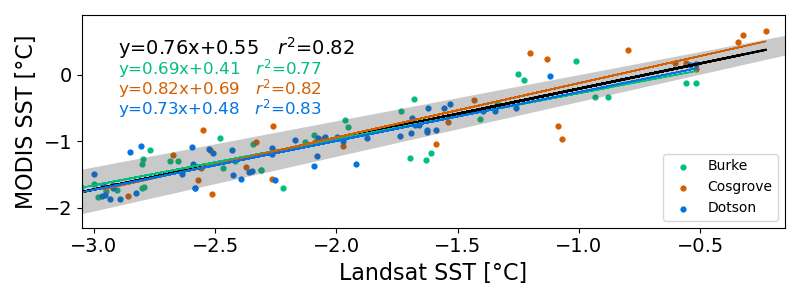

In [13]:
# Plot with all points and by region (Burke=r, Cosgrove=b, Dotson=g) - show with lsat_mod_df_n calculations for the line
beta_mdn = [odr_results['Combined']['beta'][0]-odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]-odr_results['Combined']['beta_err'][1]*1.96]
beta_mup = [odr_results['Combined']['beta'][0]+odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]-odr_results['Combined']['beta_err'][1]*1.96]
beta_bdn = [odr_results['Combined']['beta'][0]-odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]+odr_results['Combined']['beta_err'][1]*1.96]
beta_bup = [odr_results['Combined']['beta'][0]+odr_results['Combined']['beta_err'][0]*1.96,odr_results['Combined']['beta'][1]+odr_results['Combined']['beta_err'][1]*1.96]
a1 = np.around(odr_results['Combined']['beta'][0],2)
a1e = np.around(odr_results['Combined']['beta_err'][0]*1.96,2)
a2 = np.around(odr_results['Combined']['beta'][1],2)
a2e = np.around(odr_results['Combined']['beta_err'][1]*1.96,2)
nn = odr_results['Combined']['y_pred'].shape[0]
ar = np.around(odr_results['Combined']['R2'],2)
b1 = np.around(odr_results['Burke']['beta'][0],2)
b2 = np.around(odr_results['Burke']['beta'][1],2)
br = np.around(odr_results['Burke']['R2'],2)
c1 = np.around(odr_results['Cosgrove']['beta'][0],2)
c2 = np.around(odr_results['Cosgrove']['beta'][1],2)
cr = np.around(odr_results['Cosgrove']['R2'],2)
d1 = np.around(odr_results['Dotson']['beta'][0],2)
d2 = np.around(odr_results['Dotson']['beta'][1],2)
dr = np.around(odr_results['Dotson']['R2'],2)
print(f'At 95% confidence interval: {a1}+/-{a1e}, {a2}+/-{a2e}, n={nn}')
xfill = np.array([-4.3,0.9])


fig, ax = plt.subplots(figsize=(8, 3))
ax.tick_params(labelsize=14)

plt.scatter(np.array(lsat_mod_df_B[f'L8_{surf_temp}']), np.array(lsat_mod_df_B['MODIS_SST']), s=12,color='#00bf7d', label='Burke')
plt.scatter(np.array(lsat_mod_df_C[f'L8_{surf_temp}']), np.array(lsat_mod_df_C['MODIS_SST']), s=12,color=sns.color_palette("colorblind")[3], label='Cosgrove')
plt.scatter(np.array(lsat_mod_df_D[f'L8_{surf_temp}']), np.array(lsat_mod_df_D['MODIS_SST']), s=12,color='#0073e6', label='Dotson')

plt.plot(odr_results['Combined']['x_original'], odr_results['Combined']['y_pred'], color='k')
plt.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.3, facecolor='0.3')
plt.plot(odr_results['Burke']['x_original'], odr_results['Burke']['y_pred'], ls='-',linewidth=1,color='#00bf7d')
plt.plot(odr_results['Cosgrove']['x_original'], odr_results['Cosgrove']['y_pred'], ls='-',linewidth=1,color=sns.color_palette("colorblind")[3])
plt.plot(odr_results['Dotson']['x_original'], odr_results['Dotson']['y_pred'], ls='-',linewidth=1,color='#0073e6')

if surf_temp=='LST':
    plt.text(-2.25,-0.2,f'y={a1}x+{a2}   $r^2$={ar}',color='#00bf7d',fontsize=14)
    plt.text(-2.25,-0.2,f'y={c1}x+{c2}   $r^2$={cr}',color=sns.color_palette("colorblind")[3],fontsize=12)
    plt.text(-2.25,-0.2,f'y={d1}x+{d2}   $r^2$={dr}',color='#0073e6',fontsize=12)
    plt.xlim([-2.5,-1.4])
    plt.ylim([-2.05,0.0])
else: 
    plt.text(-2.9,0.3,f'y={a1}x+{a2}   $r^2$={ar}',color='k',fontsize=14)
    plt.text(-2.9,0.0,f'y={b1}x+{b2}   $r^2$={br}',color='#00bf7d',fontsize=12)
    plt.text(-2.9,-0.3,f'y={c1}x+{c2}   $r^2$={cr}',color=sns.color_palette("colorblind")[3],fontsize=12)
    plt.text(-2.9,-0.6,f'y={d1}x+{d2}   $r^2$={dr}',color='#0073e6',fontsize=12)
    plt.xlim([-3.05,-0.15])
    plt.ylim([-2.3,0.9])
plt.xlabel('Landsat SST [°C]',fontsize=16)
plt.ylabel('MODIS SST [°C]',fontsize=16)
plt.legend(loc='lower right',fontsize=10)
plt.tight_layout()

In [26]:
odr_results['Burke']['beta_err']

array([0.06232569, 0.13998075])

In [168]:
# Ordinary least squares regression between Landsat and MODIS SST matchups
resultC = sm.ols(formula="MODIS_SST ~ L8_SST", data=data0).fit()
print (resultC.summary())

                            OLS Regression Results                            
Dep. Variable:              MODIS_SST   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     255.5
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           1.03e-21
Time:                        06:21:08   Log-Likelihood:                 9.0165
No. Observations:                  54   AIC:                            -14.03
Df Residuals:                      52   BIC:                            -10.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4747      0.103      4.623      0.0